# K ближайших соседей (KNN)
Метод KNN относит объект к классу, наиболее частому среди $k$ ближайших соседей по выбранной метрике расстояния, например Евклидовой: $d(x, x') = \sqrt{\sum_{j=1}^{p} (x_j-x'_j)^2}$. Класс вычисляется по голосованию: $\hat{y} = \arg\max_c \sum_{i\in \mathcal{N}_k(x)} \mathbb{1}(y_i=c)$. Для регрессии используют среднее по соседям. Масштабирование признаков важно, так как расстояния чувствительны к масштабам.


## Используемые библиотеки
Используем `numpy`, `pandas`, `seaborn`, `matplotlib`. Из `sklearn` — `load_wine`, `train_test_split`, `StandardScaler`, `Pipeline`, `KNeighborsClassifier` и метрики классификации.


In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [20]:
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.dpi"] = 120
PRIMARY_COLOR = "#1f77b4"
HEATMAP_CMAP = "coolwarm"
CONFUSION_CMAP = "Blues"


## Датасет: описание и частичная распечатка
Датасет **Wine** — результаты химического анализа 178 вин из трёх сортов винограда Италии. 13 числовых признаков: алкоголь, яблочная кислота, зола, магний, фенолы, флавоноиды, пролин и т.д. Целевая переменная — сорт вина (0, 1, 2). Задача — мультиклассовая классификация. Признаки имеют разные масштабы (алкоголь ~12, пролин ~700), поэтому стандартизация необходима для KNN.


In [21]:
wine = load_wine(as_frame=True)
data = wine.frame
print(f"Размерность: {data.shape}")
data.head()


Размерность: (178, 14)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


## Предварительная обработка
Разделяем признаки и целевую переменную. Разбиваем на train/test со стратификацией. `StandardScaler` внутри `Pipeline` приводит все признаки к шкале с нулевым средним и единичной дисперсией — это устраняет доминирование признаков с большими абсолютными значениями при вычислении расстояний.


In [22]:
features = data.drop(columns=["target"])
target = data["target"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)


## Тепловая карта корреляций
Матрица из 14 переменных. Заметна высокая корреляция флавоноидов с фенолами и пролина с алкоголем. KNN не предполагает линейную зависимость между признаками, но мультиколлинеарность может затруднять выбор оптимального $k$ — коррелирующие признаки «дублируют» информацию в метрике расстояния.


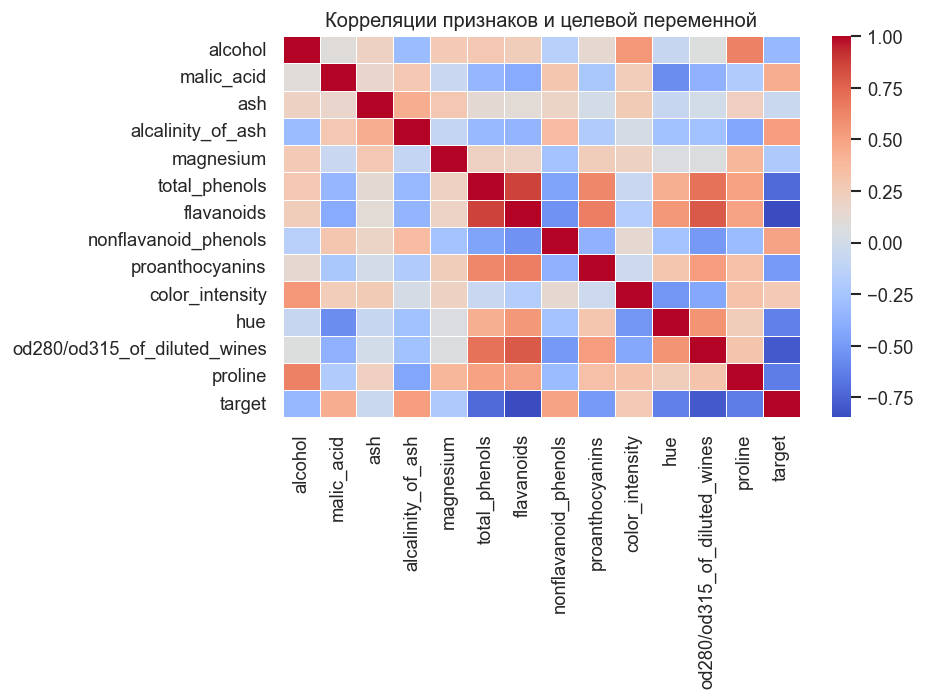

In [23]:
plt.figure(figsize=(8, 6))
correlation = data.corr()
sns.heatmap(correlation, annot=False, cmap=HEATMAP_CMAP, linewidths=0.3)
plt.title("Корреляции признаков и целевой переменной")
plt.tight_layout()
plt.show()


## Обучение модели
`Pipeline` из `StandardScaler` и `KNeighborsClassifier(n_neighbors=5)`. Выбор $k=5$ — эвристика; малые $k$ дают шумные решения (переобучение), большие $k$ сглаживают границы, но могут упускать локальные паттерны. Оптимальный $k$ обычно подбирается кросс-валидацией.


In [24]:
model = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=5)),
    ]
)
model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

## Прогнозы модели
Вычисляем метрики с усреднением `weighted`:
- **Accuracy** — общая точность;
- **Precision/Recall/F1** — взвешенные по размеру классов.

KNN без настройки $k$ обычно дает хорошие результаты на Iris/Wine-подобных датасетах с хорошо разделёнными кластерами.


In [25]:
y_pred = model.predict(X_test)

print("KNN Metrics")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred, average='weighted'):.3f}")
print(f"F1:        {f1_score(y_test, y_pred, average='weighted'):.3f}")


KNN Metrics
Accuracy:  0.972
Precision: 0.975
Recall:    0.972
F1:        0.972


## Графики выходных результатов
**График 1. Матрица ошибок.** Показывает систематические ошибки: какие сорта чаще путаются. KNN чувствителен к выбросам — единственный неверно классифицированный образец может дать «полосу» ошибок.

**График 2. Точность по классам.** Позволяет оценить сбалансированность качества: если один класс значительно хуже других, стоит проверить его представительность в обучающей выборке или подобрать другое $k$.


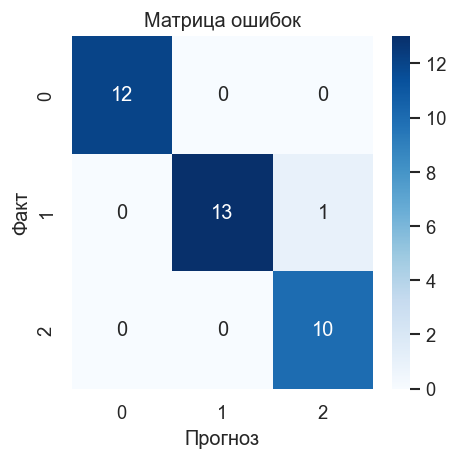

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap=CONFUSION_CMAP)
plt.title("Матрица ошибок")
plt.xlabel("Прогноз")
plt.ylabel("Факт")
plt.tight_layout()
plt.show()


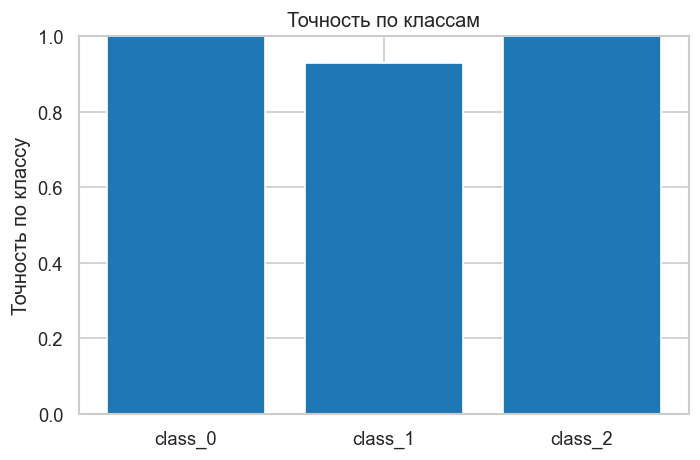

In [27]:
class_names = wine.target_names
per_class_acc = []
for cls in np.unique(y_test):
    mask = y_test == cls
    per_class_acc.append(np.mean(y_pred[mask] == y_test[mask]))

plt.figure(figsize=(6, 4))
plt.bar(class_names, per_class_acc, color=PRIMARY_COLOR)
plt.ylim(0, 1)
plt.ylabel("Точность по классу")
plt.title("Точность по классам")
plt.tight_layout()
plt.show()
